In [2]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

2025-08-18 23:30:53.281242: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-18 23:30:53.288027: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 23:30:53.517004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-18 23:30:54.446378: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

## Obtendo um conjunto de dados

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imbikramsaha/caltech-101")

!cp -r {path+'/*'} /home/watcher/Documentos/Transfer-Learning-Study/datasets/

path = '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101'

print("Path to dataset files:", path)

/home/watcher/Documentos/Transfer-Learning-Study/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101


In [4]:
root = path
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/cannon', '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/saxophone', '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/panda', '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/bass', '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/headphone', '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/Leopards', '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/kangaroo', '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/tick', '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/butterfly', '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/accordion', '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/inline_skate', '/home/watcher/Documentos/Transfer-Learning-Study/datasets/caltech-101/lobster', '/home/watcher/Docume

Esta função é útil para pré-processar os dados em uma imagem e um vetor de entrada.

In [5]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregue todas as imagens da pasta raiz

In [6]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize a ordem dos dados.

In [7]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [8]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Dados separados para rótulos.

In [9]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[91, 26, 46, 27, 32, 86, 64, 59, 55, 66, 69, 14, 1, 65, 62, 77, 80, 35, 79, 23, 17, 88, 54, 15, 65, 36, 5, 77, 32, 14, 30, 39, 48, 46, 86, 19, 77, 69, 20, 49, 83, 6, 23, 51, 69, 89, 52, 51, 21, 35, 54, 21, 84, 5, 19, 27, 14, 22, 51, 53, 68, 5, 77, 62, 7, 75, 23, 54, 70, 77, 31, 85, 88, 56, 79, 79, 49, 64, 17, 49, 20, 39, 46, 30, 57, 18, 88, 24, 5, 56, 34, 55, 23, 5, 49, 70, 17, 4, 24, 84, 15, 54, 51, 96, 32, 9, 19, 54, 61, 17, 85, 1, 58, 32, 78, 54, 64, 43, 77, 91, 96, 59, 5, 53, 20, 83, 5, 38, 78, 94, 62, 83, 69, 19, 92, 9, 47, 21, 6, 9, 66, 43, 25, 47, 42, 35, 51, 28, 51, 8, 91, 66, 35, 90, 49, 61, 55, 28, 19, 81, 6, 16, 70, 23, 69, 25, 96, 96, 9, 53, 53, 79, 54, 88, 17, 36, 65, 18, 82, 20, 16, 21, 63, 60, 48, 19, 28, 51, 0, 88, 90, 50, 77, 51, 80, 38, 88, 84, 84, 31, 63, 49, 35, 10, 30, 51, 80, 68, 79, 24, 62, 46, 18, 66, 78, 35, 70, 31, 50, 8, 93, 79, 54, 88, 51, 3, 55, 49, 19, 20, 96, 50, 67, 51, 88, 22, 63, 61, 51, 68, 76, 76, 62, 67, 50, 80, 55, 15, 5, 75, 96, 55, 19, 1, 35, 96,

Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [10]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


Vamos fazer um resumo do que temos.

In [11]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


Se tudo funcionou corretamente, você deve ter carregado várias imagens e dividido-as em três conjuntos: "train", "val" e "test". O formato dos dados de treinamento deve ser (n, 224, 224, 3), onde n é o tamanho do seu conjunto de treinamento, e os rótulos devem ser (n, c), onde c é o número de classes (97 no caso de 101_ObjectCategories).

Observe que dividimos todos os dados em três subconjuntos — um conjunto de treinamento "train", um conjunto de validação "val" e um conjunto de teste "test". O motivo disso é avaliar corretamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem sobreajustar o conjunto de treinamento. O conjunto de teste é sempre mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

Vamos dar uma olhada rápida em algumas imagens de exemplo do nosso conjunto de dados.

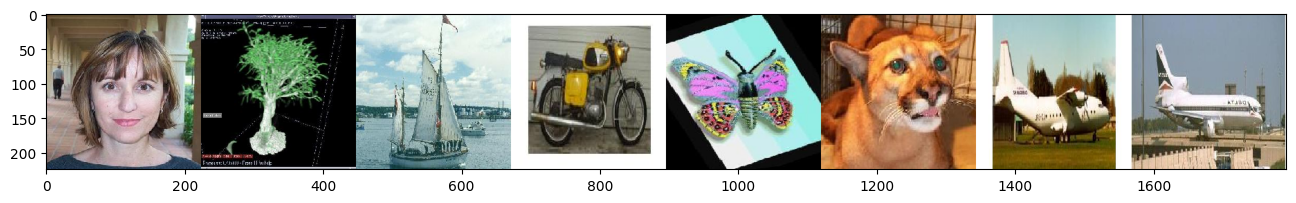

In [12]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Primeiro treinamento de uma rede neural do zero

Antes de realizar a transferência de aprendizado, vamos primeiro construir uma rede neural do zero para realizar a classificação em nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede aprendida por transferência posteriormente.

A rede que construiremos contém 4 camadas convolucionais e de pooling máximo alternadas, seguidas por um dropout após cada par conv/pooling. Após a última camada de pooling, anexaremos uma camada totalmente conectada com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como de costume, a perda de entropia cruzada categórica, e nosso algoritmo de aprendizado será o AdaDelta. Vários aspectos dessa rede podem ser alterados para obter melhor desempenho; talvez usar uma rede maior ou um otimizador diferente ajude, mas, para os propósitos deste caderno, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação, portanto, não é necessário gastar muito tempo tentando otimizar esta rede.

Após compilar a rede, vamos executar model.summary() para obter um instantâneo de suas camadas.

In [13]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/home/watcher/Documentos/Transfer-Learning-Study/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1755570662.290317  141583 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1755570662.299038  141583 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 97)             │        24,929 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 97)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,233,473 (4.71 MB)

 Trainable params: 1,233,473 (4.71 MB)

 Non-trainable params: 0 (0.00 B)

Criamos uma rede de médio porte com aproximadamente 1,2 milhão de pesos e vieses (os parâmetros). A maioria deles leva à camada totalmente conectada pré-softmax "dense_5".

Agora podemos prosseguir e treinar nosso modelo para 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos plotar a perda ao longo do tempo posteriormente.

In [14]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 345ms/step - accuracy: 0.0506 - loss: 4.4941 - val_accuracy: 0.0612 - val_loss: 4.3823
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.1075 - loss: 4.1819 - val_accuracy: 0.1697 - val_loss: 3.9876
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 343ms/step - accuracy: 0.1825 - loss: 3.7467 - val_accuracy: 0.2599 - val_loss: 3.5059
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.2598 - loss: 3.3441 - val_accuracy: 0.2922 - val_loss: 3.2197
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.3116 - loss: 3.0193 - val_accuracy: 0.3437 - val_loss: 2.9392
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.3647 - loss: 2.6789 - val_accuracy: 0.3555 - val_loss: 2.8391
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.4301 - loss: 2.3326 - val_accuracy: 0.3974 - val_loss: 2.6725
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.4779 - loss: 2.0754 - val_accu

In [15]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Vamos traçar a perda de validação e a precisão da validação ao longo do tempo.

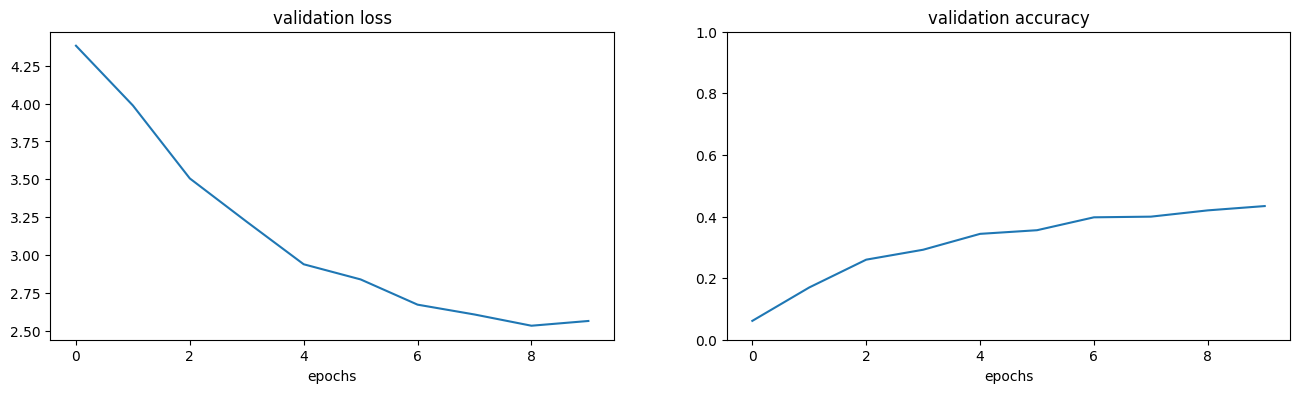

In [16]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que a perda de validação começa a aumentar após cerca de 16 períodos, embora a precisão da validação permaneça aproximadamente entre 40% e 50%. Isso sugere que nosso modelo começa a apresentar overfitting por volta dessa época, e um desempenho melhor teria sido alcançado se tivéssemos parado antes, por volta dessa época. No entanto, nossa precisão provavelmente não teria sido superior a 50%, e provavelmente menor.

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [17]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.5566115379333496
Test accuracy: 0.43884119391441345


Por fim, vemos que alcançamos uma precisão (top-1) de cerca de 49%. Isso não é tão ruim para 6.000 imagens, considerando que, se tivéssemos usado uma estratégia ingênua de fazer suposições aleatórias, teríamos obtido apenas cerca de 1% de precisão.

## Transferência de aprendizagem começando com a rede existente

Agora podemos passar para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começar com uma rede maior e já treinada.

Para começar, carregaremos o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta for a primeira vez que você carrega o VGG16, precisará aguardar um pouco para que os pesos sejam baixados da web. Assim que a rede for carregada, podemos inspecionar as camadas novamente com o método summary().

In [18]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Observe que o VGG16 é muito maior do que a rede que construímos anteriormente. Ele contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e possui mais de 138 milhões de parâmetros, cerca de 100 vezes mais parâmetros do que a rede que criamos acima. Assim como nossa primeira rede, a maioria dos parâmetros é armazenada nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi criado para resolver o ImageNet e atinge uma taxa de erro de 8,8% nas 5 principais previsões, o que significa que 91,2% das amostras de teste foram classificadas corretamente dentro das 5 principais previsões para cada imagem. Sua precisão de 1ª ordem — equivalente à métrica de precisão que temos usado (de que a previsão mais alta está correta) — é de 73%. Isso é especialmente impressionante, pois não há apenas 97, mas 1.000 classes, o que significa que palpites aleatórios nos dariam apenas 0,1% de precisão.

Para usar essa rede em nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados 101_ObjectCategories.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG de sua camada de entrada até a penúltima camada e, em seguida, trabalhar com ela, em vez de modificar o objeto VGG diretamente. Portanto, tecnicamente, nunca "removemos" nada, apenas o contornamos/ignoramos. Isso pode ser feito da seguinte maneira: usando a classe Model do Keras para inicializar um novo modelo cuja camada de entrada é a mesma do VGG, mas cuja camada de saída é nossa nova camada softmax, chamada new_classification_layer. Observação: embora pareça que estamos duplicando essa grande rede, internamente o Keras está, na verdade, apenas copiando todas as camadas por referência e, portanto, não precisamos nos preocupar em sobrecarregar a memória.